# Chapter 8 [어텐션]
---
이번 장에서는 seq2seq를 한층 더 강력하게 해주는 어텐션 메커니즘에 대해 살펴보겠습니다.

## 1. 어텐션의 구조

### seq2seq의 문제점
---
seq2seq에서는 Encoder가 시계열 데이터를 인코딩합니다.  
이때 Encoder의 출력은 '고정 길이의 벡터'였습니다.  
고정 길이의 벡터라 함은 입력 문장의 길이에 관계없이, 항상 같은 길이의 벡터로 변환한다는 뜻입니다.  
<img src=img/fig8-1.png width='600'>  
문장이 길어지면 결국 필요한 정보들을 벡터에 다 담지 못하게 됩니다.  

### Encoder 개선
---
위 문제점을 개선하는 방법으로 각 시각별 LSTM 계층의 은닉 상태 벡터를 모두 이용하는 것입니다.  
<img src=img/fig8-2.png width='700'>  
이렇게 각 시각의 은닉 상태 벡터를 모두 이용하면 입력된 데이터와 같은 수의 벡터를 얻을 수 있습니다.  
위 예에서는 5개의 단어가 입력되었고, 이때 Encoder는 5개의 벡터를 출력합니다.  
이것으로 Encoder는 '하나의 고정 길이 벡터'라는 제약으로부터 해방됩니다.  
<img src=img/fig8-3.png width='700'>  

### Decoder 개선 ①
---
이전 Decoder에서는 Encoder의 마지막 은닉 상태 벡터만 들어왔습니다만, 위의 개선된 Encoder에서는 모든 은닉 상태 벡터 **hs**가 넘어옵니다.  
이 **hs**를 전부 활용할 수 있도록 Decoder를 개선 시키겠습니다.  

그 전에 '나 = I'나 '고양이 = cat' 처럼 각 단어의 대응 관계를 seq2seq에게 학습시킬 수는 없을까요?
앞으로 우리의 목표는 '도착어 단어'와 대응 관계에 있는 '출발어 단어'의 정보를 골라내는 것입니다.  
그리고 그 정보를 이용하여 번역을 수행하는 것입니다.  
다시 말해, 필요한 정보에만 주목하여 그 정보로부터 시계열 변환을 수행하는 것이 목표입니다.  
이 구조를 어텐션이라 부르며, 이번 장의 핵심 주제입니다.  
<img src=img/fig8-6.png width='700'>  
위 그림처럼 새롭게 '어떤 계산'을 수행하는 계층을 추가할 겁니다.  
이 '어떤 계산'이 받는 입력은 두 가지로, 하나는 Encoder로부터 받는 hs이고, 다른 하나는 시각별 LSTM계층의 은닉 상태입니다.  
참고로, 지금까지와 똑같이 Encoder의 마지막 은닉 상태 벡터는 Decoder의 첫 번째 LSTM 계층에 전달합니다.  

위 신경망으로 하고 싶은 일은 단어들의 얼라인먼트 추출입니다.  
각 시각에서 Decoder에 입력된 단어와 대응 관계인 단어의 벡터를 **hs**에서 골라내겠다는 뜻입니다.  
예컨대 그림의 Decoder가 "I"를 출력할 때, **hs**에서 "나"에 대응하는 벡터를 선택하면 됩니다.  
그리고 이러한 '선택'작업을 '어떤 계산'으로 해내겠다는 것입니다.  
하지만 여기서 문제가 발생합니다. 바로 선택하는 작업은 미분할 수 없다는 점입니다.  

이 문제를 해결할 아이디어는 '하나를 선택'하는게 아니라, '모든 것을 선택'한다는 것입니다.  
그리고 이때 아래 그림과 같이 각 단어의 중요도를 나타내는 '가중치'를 별도로 계산하도록 합니다.  
<img src=img/fig8-7.png width='700'>  
<img src=img/fig8-8.png width='700'>  
이렇게 맥락 벡터 **c**에는 "나" 벡터의 성분이 많이 포함되어 있다는 것입니다.  
즉 "나" 벡터를 선택하는 작업을 이 가중합으로 대체할 수 있습니다.  

### Decoder 개선 ②
---
각 단어의 중요도를 나타내는 가중치 **a**가 있다면, 가중합을 이용해 '맥락 벡터'를 얻을 수 있습니다.  
그런데 이 **a**는 어떻게 구해야 할까요?  
<img src=img/fig8-12.png width='500'>  
그림에서는 Decoder의 LSTM 계층의 은닉 상태 벡터를 **h**라 했습니다.  
지금 목표는 이 **h**가 **hs**의 각 단어 벡터와 얼마나 '비슷한가'를 수치로 나타내는 것입니다.  
여기에서는 가장 단순한 방법인 벡터의 '내적'을 이용하고자 합니다.  
참고로 두 벡터 $\mathrm{a=(a_{1},a_{2},\cdots,a_{n})}$와 $\mathrm{b=(b_{1},b_{2},\cdots,b_{n})}$의 내적은 다음과 같이 계산합니다.  

$$ \large{\mathrm{a\cdot b = a_{1}b_{1} + a_{2}b_{2} + \cdots + a_{n}b_{n}}} $$  
내적의 직관적인 의미는 '두 벡터가 얼마나 같은 방향을 향하고 있는가'입니다.  
따라서 두 벡터의 '유사도'를 표현하는 척도로 내적을 이용합니다.  
<img src=img/fig8-13.png width='500'>  
여기에서는 벡터의 내적을 이용해 **h**와 **hs**의 각 단어 벡터와의 유사도를 구합니다.  
그리고 **s**는 그 결과입니다. **s**는 정규화하기 전의 값이며, 소프트맥스 함수를 적용하여 정규화 합니다.  
<img src=img/fig8-14.png width='400'>  

### Decoder 개선 ③
---
지금까지 Decoder 개선안을 두 가지로 나눠 알아보았습니다.  
Decoder 개선 ① 에서는 Weight Sum 계층을, Decoder 개선 ② 에서는 Attention weight 계층을 알아보았습니다.  
이 두 계층을 하나로 결합하여 Attention 계층으로 부르겠습니다.  
<img src=img/fig8-16.png width='700'>  
<img src=img/fig8-17.png width='700'>  

In [1]:
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Softmax

class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1)#.repeat(T, axis=1)
        t = hs * ar
        c = np.sum(t, axis=1)

        self.cache = (hs, ar)
        return c

    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)

        return dhs, da

class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh

class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh


class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec

## 2. 어텐션을 갖춘 seq2seq 구현

### Encoder 구현
---

In [2]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.seq2seq import Encoder, Seq2seq

class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### Decoder 구현
---

In [3]:
class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled

### seq2seq 구현
---

In [4]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

## 3. 어텐션 평가

### 날짜 형식 변환 문제
---
이번 절에서는 영어권에서 사용되는 다양한 날짜 형식을 표준 형식으로 변환하는 것이 목표입니다.  
<img src=img/fig8-22.png width='500'>  
날짜 형식 변환 문제는 간단하지 않고, 입력과 출력 사이에 명확한 대응 관계가 있기 때문입니다.  
<img src=img/fig8-23.png width='500'>  

### 어텐션을 갖춘 seq2seq의 학습
---

In [5]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('정확도 %.3f%%' % (acc * 100))


model.save_params()

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 10[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 20[s] | 손실 1.90
| 에폭 1 |  반복 61 / 351 | 시간 30[s] | 손실 1.72
| 에폭 1 |  반복 81 / 351 | 시간 40[s] | 손실 1.46
| 에폭 1 |  반복 101 / 351 | 시간 49[s] | 손실 1.19
| 에폭 1 |  반복 121 / 351 | 시간 59[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 68[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 78[s] | 손실 1.06
| 에폭 1 |  반복 181 / 351 | 시간 88[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 97[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 107[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 116[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 126[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 135[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 145[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 154[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 164[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
X 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
X 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
X 1978-08-11
---
Q Tuesday, November 22

KeyboardInterrupt: 

<img src=img/fig8-25.png width='400'>  
<img src=img/fig8-26.png width='500'>  

### 어텐션 시각화
---
<img src=img/fig8-27.png width='500'>  
위 그림은 seq2seq가 시계열 변환을 할 때의 어텐션 가중치를 시각화한 결과입니다.  
예컨대 seq2seq가 최초의 "1"을 출력할 때는 입력 문장의 "1"위치에 표시가 됩니다.  
이렇게 세로축(출력)의 "1983"과 "26"이 가로축(입력)의 "1983"과 "26"에 대응하고 있습니다.  
또한 월을 뜻하는 "08"에 입력 문장의 "AUGUST"가 대응하고 있는 점은 놀랍습니다.  

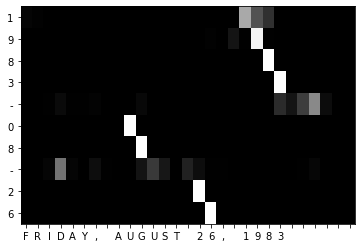

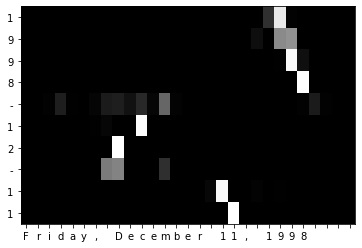

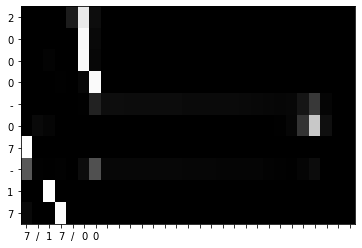

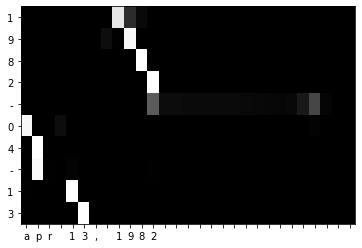

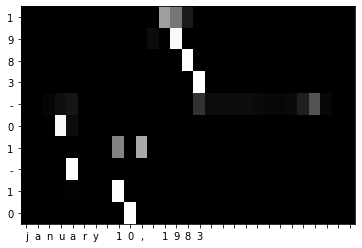

In [6]:
import sys
sys.path.append('..')
import numpy as np
from dataset import sequence
import matplotlib.pyplot as plt


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # 출력하기 위해 반전
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)